In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # >= 0.9
sns.set(style='ticks', context='talk', color_codes=True)

In [154]:
mpl.rcParams.update({
    'figure.figsize': [10, 6],
    'legend.fontsize': 18,
    'lines.linewidth' : 5,
    'patch.linewidth': 2.2,
    'hatch.linewidth': 2,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.minor.visible': True,
    'ytick.minor.visible': True
})

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Preamble



Type Ia supernovae (SNe Ia) are generally thought to be the thermonuclear disruption of a carbon-oxygen white-dwarf star (WD) in a binary system (see, e.g., Hillebrandt & Niemeyer 2000 for a review), but their formation scenarios and exact progenitor systems are still ambiguous. The photospheric velocity of SNe Ia measured from the strong Si II λ6355 absorption line in their spectrum (e.g., Silverman et al. 2012) at the time of peak brightness is an important parameter for studying the various properties of SNe Ia. The ejecta velocity distribution is also a possible clue for revealing asymmetries in SN Ia explosions. Recent studies reveal that the distribution of SN Ia velocity does not originate from a uniform class. [Wang, X. et al. (2013)](https://arxiv.org/abs/1303.2601) and [Zheng et al. (2018)](https://arxiv.org/abs/1712.01495) show that there exists a subclass of SNe Ia with high velocities (Figures 1 and 2), indicating a different origin for some SNe Ia.

Asymmetric SN Ia explosions could cause different measured ejecta velocities observed from different lines of sight. We intend to model the ejecta velocity of SNe Ia seen from different lines of sight through numerical simulations to test if the simulated velocity distribution could match the observed velocity distribution. We expect the model to demonstrate properties of velocity, ejecta size, and rarity of the high-velocity ejecta compared to the low-velocity. The results of the simulations will be a random sample of the velocity distribution to be compared with the real data.

Due to the limited time alloted for this project, a few descoping option was used. The original method of parameter estimation was MCMC which the posterior of the parameters were difficult to interpret. Further convergence test was needed therefore I decided MCMC was too time consuming. Parameter estimation was descoped form MCMC to grid search which provides a single set of best estimated parameters instead of a posterior. A quality slice in Si II velocity was also made to descope so that the methods matches those in Wang, X. et al. (2013) easily. Finally, the last descope made as assuming that all SNe Ia have high-velocity ejecta instead of using a prior.


# The Data

The dataset comes from the kaepora database ([Siebert, M. R. et al. 2019](https://academic.oup.com/mnras/article/486/4/5785/5484870)). It consists of 311 Si II velocities from SNe Ia.

In [155]:
from dataloader import *

sn_data = import_kaepora()
sn_data.head()

,v_siII,v_siII_err,z
kaepora,,,
2006td,10812.60,300.000,0.015880
1996z,12142.10,233.568,0.007575
1996x,11173.10,222.453,0.006945
1996c,10689.10,222.453,0.027000
2005m,8093.94,231.052,0.022000


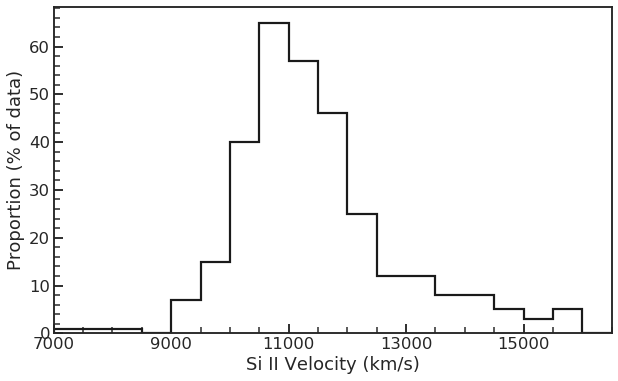

In [173]:
bins = np.arange(7000, 17000, 500)
plt.hist(sn_data['v_siII'], bins=bins, color='k', histtype='step', label='Observed')

# Plot config
plt.xticks(bins[::4])
plt.xlim(bins.min(), bins.max())
# yticks = plt.yticks()[0] * 500 * 100
# yticks = np.arange(yticks.min(), yticks.max() + 1, 2) / (500 * 100)
# ytickslabel = [f'{tick:.2g}' for tick in yticks * 500 * 100]
# plt.yticks(yticks, ytickslabel)
plt.xlabel('Si II Velocity (km/s)')
plt.ylabel('Proportion (% of data)')

plt.savefig('results/velocity_dist_raw.eps', orientation='landscape', format='eps', )

The data is fitted by a maximum likelihood estimator on a unimodal Gaussian distribution then a bimodal Gaussian distribution.

## Comparing to Other Datasets

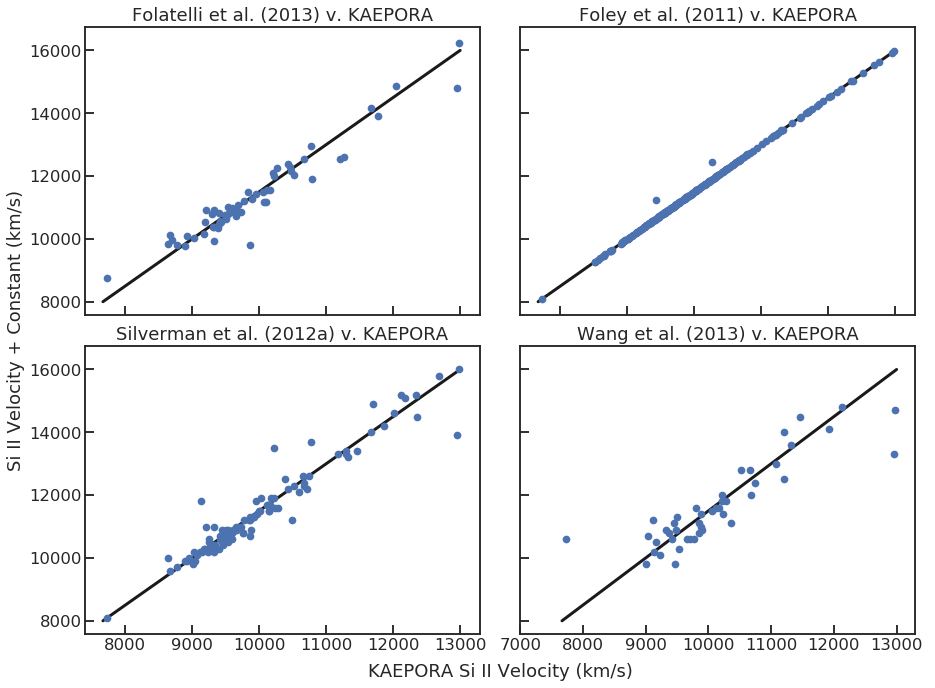

In [6]:
dataset = [import_folatelli13(), import_foley11(), import_wang13(), import_zheng18()]
labels = ['Folatelli et al. (2013)',
 'Foley et al. (2011)',
 'Silverman et al. (2012a)',
 'Wang et al. (2013)',
 'Zheng et al. (2018)']

nrows, ncols = 2, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(7*ncols, 5*nrows), sharex=True, sharey=True)

for i in range(nrows*ncols):
    ax = axs[i//ncols, i%ncols]
    d = dataset[i]
    
    ax.plot([8000, 16000], [8000, 16000], 'k', linewidth=3, zorder=1)
    
    overlap = set(sn_data.index).intersection(set(dataset[i].index))
    ax.scatter(sn_data.loc[overlap, 'v_siII'], d.loc[overlap, 'v_siII'], s=30, zorder=2)
    ax.set_title(f'{labels[i]} v. KAEPORA')
    
    ticks = bins[::3]
    tickslabel = np.array([f'{tick:.0f}' for tick in bins[::2]])
    ax.set_xticks(ticks)
    ax.set_xticklabels(tickslabel)

# Outer Element
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.xlabel('KAEPORA Si II Velocity (km/s)', labelpad=10)
plt.ylabel('Si II Velocity + Constant (km/s)', labelpad=30)

plt.tight_layout()
plt.savefig('results/overlap_data.eps', orientation='landscape', format='eps');

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


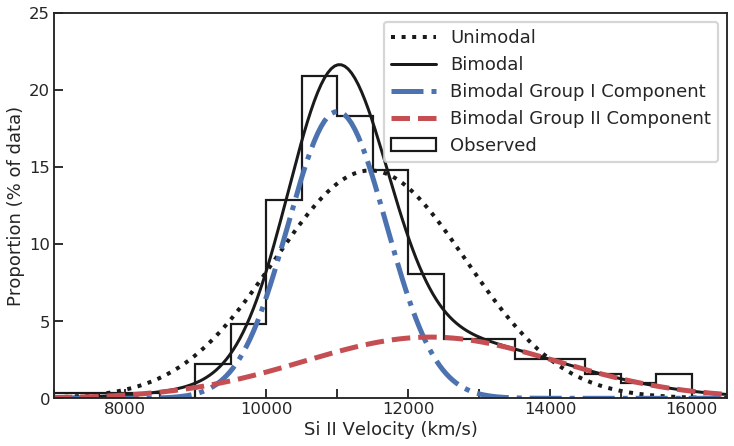

In [7]:
from scipy.optimize import curve_fit
from models import *

UNIMODAL_PARAMS = np.loadtxt('results/unimodal_params.csv', delimiter=',')
BIMODAL_PARAMS = np.loadtxt('results/bimodal_params.csv', delimiter=',')

x = sn_data['v_siII']
bins = np.arange(7000, 17000, 500)
plt.hist(x, density=True, bins=bins, color='k', histtype='step', label='Observed')

# Unimodal Gaussian
xrange = np.linspace(bins.min(), bins.max(), 200)
ydata, xdata = np.histogram(x, bins=bins, density=True)
xdata = (xdata[:-1] + xdata[1:]) / 2
plt.plot(xrange, gaussian(xrange, *UNIMODAL_PARAMS), 'k', linestyle='dotted', linewidth=4, zorder=0, label='Unimodal')

g1 = BIMODAL_PARAMS[4]
lv_dist = g1 * gaussian(xrange, *BIMODAL_PARAMS[0:2])
hv_dist = (1-g1) * gaussian(xrange, *BIMODAL_PARAMS[2:4])
plt.plot(xrange, lv_dist + hv_dist, 'k', linewidth=3, zorder=0, label='Bimodal')
plt.plot(xrange, lv_dist, 'b', linestyle='dashdot', zorder=1, label='Bimodal Group I Component')
plt.plot(xrange, hv_dist, 'r', linestyle='dashed', zorder=1, label='Bimodal Group II Component')

# Plot config
xticks = bins[::2]
xtickslabel = np.array([f'{tick:.0f}' for tick in bins[::2]])
xtickslabel[::2] = ''
plt.xticks(bins[::2], xtickslabel)
plt.xlim(bins.min(), bins.max())
plt.ylim(0, 25 / 500 / 100)
yticks = plt.yticks()[0] * 500 * 100
yticks = np.arange(yticks.min(), yticks.max() + 1, 5) / (500 * 100)
ytickslabel = [f'{tick:.2g}' for tick in yticks * 500 * 100]
plt.yticks(yticks, ytickslabel)
plt.xlabel('Si II Velocity (km/s)')
plt.ylabel('Proportion (% of data)')
plt.legend(loc='upper right', fontsize=18, handlelength=2.5)

# Save results
plt.tight_layout(pad=0)
plt.savefig('results/velocity_dist.eps', orientation='landscape', format='eps', )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


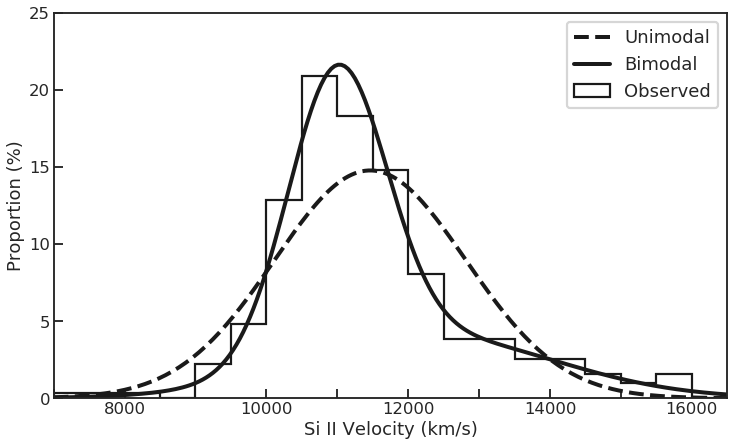

In [8]:
x = sn_data['v_siII']
bins = np.arange(7000, 17000, 500)
plt.hist(x, density=True, bins=bins, color='k', histtype='step', label='Observed')

# Unimodal Gaussian
xrange = np.linspace(bins.min(), bins.max(), 200)
ydata, xdata = np.histogram(x, bins=bins, density=True)
xdata = (xdata[:-1] + xdata[1:]) / 2
plt.plot(xrange, gaussian(xrange, *UNIMODAL_PARAMS), '--k', lw=4, label='Unimodal')

g1 = BIMODAL_PARAMS[4]
lv_dist = g1 * gaussian(xrange, *BIMODAL_PARAMS[0:2])
hv_dist = (1-g1) * gaussian(xrange, *BIMODAL_PARAMS[2:4])
plt.plot(xrange, lv_dist + hv_dist, 'k', lw=4, label='Bimodal')

# Plot config
xticks = bins[::2]
xtickslabel = np.array([f'{tick:.0f}' for tick in bins[::2]])
xtickslabel[::2] = ''
plt.xticks(bins[::2], xtickslabel)
plt.xlim(bins.min(), bins.max())
yticks = plt.yticks()[0] * 500 * 100
yticks = np.arange(yticks.min(), yticks.max() + 1, 5) / (500 * 100)
ytickslabel = [f'{tick:.2g}' for tick in yticks * 500 * 100]
plt.yticks(yticks, ytickslabel)
plt.xlabel('Si II Velocity (km/s)')
plt.ylabel('Proportion (%)')
plt.legend(loc='upper right', fontsize=18)

# Save results
plt.tight_layout(pad=0)
plt.savefig('results/velocity_dist_sum.eps', orientation='landscape', format='eps', )

In [9]:
# dataset = [import_folatelli13(), import_foley11(), import_wang13(), import_zheng18()]
# labels = ['Folatelli et al. (2013)',
#  'Foley et al. (2011)',
#  'Silverman et al. (2012a)',
#  'Wang et al. (2013)',
#  'Zheng et al. (2018)']

# markers = [
#     'o', 's', '^', 'x'
# ]
# y_offset = 3000

# plt.figure(figsize=(10,10))
# for i, d in enumerate(dataset):
#     overlap = set(sn_data.index).intersection(set(d.index))
#     plt.plot([8000, 16000], [8000 + y_offset*(4-i), 16000 + y_offset*(4-i)], 'k', linewidth=3, zorder=1)
#     plt.scatter(
#         sn_data.loc[overlap, 'v_siII'], 
#         d.loc[overlap, 'v_siII'] + y_offset*(4-i), 
#         marker=markers[i], s=20, zorder=2, label=labels[i])
    

# ticks = bins[::2]
# tickslabel = np.array([f'{tick:.0f}' for tick in bins[::2]])
# plt.xticks(ticks, tickslabel)

# plt.xlabel('KAEPORA Si II Velocity (km/s)')
# plt.ylabel('Si II Velocity + Constant (km/s)')

# plt.legend()
# plt.savefig('results/overlap_data.eps', orientation='landscape', format='eps');

## Bimodal Justification

In [10]:
def lnlike(x, params):
    mu, sigma = params
    prob = gaussian(x, mu, sigma)
    lnl = sum(np.log(prob))
    return lnl

unimodal_lnl = lnlike(sn_data['v_siII'], UNIMODAL_PARAMS)

def lnlike(x, params):
    mu1, sigma1, mu2, sigma2, g = params
    prob1 = gaussian(x, mu1, sigma1)
    prob2 = gaussian(x, mu2, sigma2)
    prob = g * prob1 + (1 - g) * prob2
    lnl = sum(np.log(prob))
    return lnl


def aic(lnl, nparams):
    return 2  * nparams - 2 * lnl


def aicc(lnl, n, nparams):
    c = (2*nparams**2 + 2*nparams) / (n - nparams - 1)
    return aic(lnl, nparams) + c

bimodal_lnl = lnlike(sn_data['v_siII'], BIMODAL_PARAMS)

_ = pd.DataFrame(
    [
        [unimodal_lnl, -2*unimodal_lnl, aicc(unimodal_lnl, 3, len(sn_data))],
        [bimodal_lnl, -2*bimodal_lnl, aicc(bimodal_lnl, 5, len(sn_data))],
    ],
    columns=['Log-Likelihood', '$\chi^2$', 'AICc'],
    index=['Unimodal', 'Bimodal']
)

diff = _.loc['Unimodal', :] - _.loc['Bimodal', :]
diff.name = 'Difference'
display(_.append(diff))
_ = pd.DataFrame([UNIMODAL_PARAMS, BIMODAL_PARAMS], columns=['$\mu_1$', '$\sigma_1$', '$\mu_2$', '$\sigma_2$', '$g$'], index=['Unimodal', 'Bimodal'])
print(_.to_latex(float_format="%.6g", escape=False, column_format='lccr'))

,Log-Likelihood,$\chi^2$,AICc
Unimodal,-2682.910172,5365.820344,5359.781509
Bimodal,-2647.779830,5295.559660,5285.429367
Difference,-35.130342,70.260683,74.352142


\begin{tabular}{lccr}
\toprule
{} &  $\mu_1$ &  $\sigma_1$ &  $\mu_2$ &  $\sigma_2$ &      $g$ \\
\midrule
Unimodal &  11464.1 &      1349.9 &      NaN &         NaN &      NaN \\
Bimodal  &  10999.7 &     693.102 &  12312.4 &     1777.63 & 0.646264 \\
\bottomrule
\end{tabular}



Because $\chi^2_3 > 7.82$ (p-value < 5%), we consider the improvement from the unimodal to the bimodal fit to be significant.

# Motivation

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


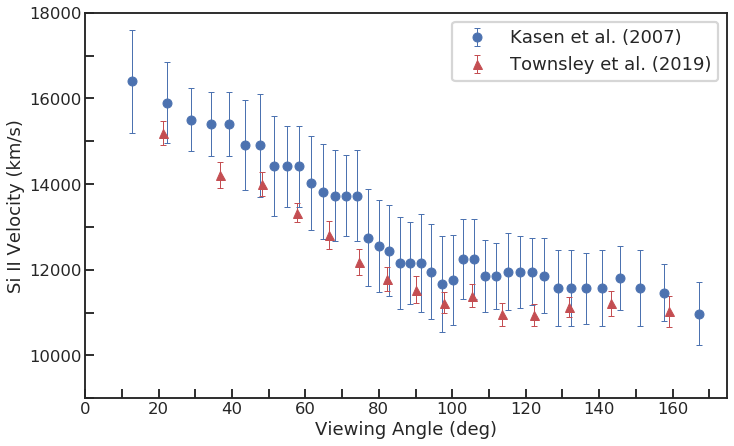

In [56]:
kasen_model = import_kasen07()
plt.errorbar(kasen_model['viewing_angle'], kasen_model['v_siII'], yerr=kasen_model['v_siII_err'], 
             fmt='o', elinewidth=1, capsize=3, capthick=1, label='Kasen et al. (2007)')

townsley_model = import_townsley19()
plt.errorbar(townsley_model['viewing_angle'], townsley_model['v_siII'], yerr=townsley_model['v_siII_err'], 
             fmt='^', elinewidth=1, capsize=3, capthick=1, color='r', label='Townsley et al. (2019)')

ytickslabel = np.array(plt.yticks()[0]).astype(int).astype(str)
ytickslabel[::2] = ''
plt.yticks(plt.yticks()[0], ytickslabel)

xticks = np.arange(0, 171, 10)
xtickslabel = xticks.astype(str)
xtickslabel[1::2] = ''
plt.xticks(xticks, xtickslabel)

plt.xlabel('Viewing Angle (deg)')
plt.ylabel('Si II Velocity (km/s)')
plt.tight_layout(pad=0)
plt.legend()

plt.savefig('results/Kasen07_velocity_plot.eps', orientation='landscape', format='eps', )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


98.66, 11754.1, -5668
97.74, 11112.1, -5222


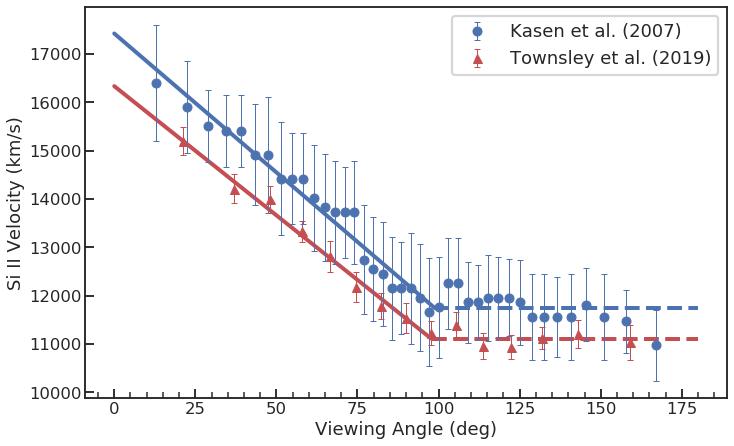

In [152]:
def piecewise_linear(x, x0, y0, m1):
    l1 = m1 * x + (y0 - m1 * x0)
    l2 = 0 * x + (y0 - 0 * x0)
    
    return np.choose(x <= x0, [l2, l1])

x = np.linspace(0, 180,1000)


plt.errorbar(kasen_model['viewing_angle'], kasen_model['v_siII'], yerr=kasen_model['v_siII_err'], 
             fmt='o', elinewidth=1, capsize=3, capthick=1, zorder=2, label='Kasen et al. (2007)')
params, _ = curve_fit(piecewise_linear, kasen_model['viewing_angle'], kasen_model['v_siII'], p0=[100, 12000, -4000/60])
print(f"{params[0]:.4g}, {params[1]:.6g}, {params[2]*params[0]:.4g}")
plt.plot(x[x <= params[0]], piecewise_linear(x, *params)[x <= params[0]], color='b', lw=4, zorder=1)
plt.plot(x[x > params[0]], piecewise_linear(x, *params)[x > params[0]], color='b', lw=4, zorder=1, ls='--')

plt.errorbar(townsley_model['viewing_angle'], townsley_model['v_siII'], yerr=townsley_model['v_siII_err'], 
             fmt='^', elinewidth=1, capsize=3, capthick=1, color='r', zorder=2, label='Townsley et al. (2019)')
params, _ = curve_fit(piecewise_linear, townsley_model['viewing_angle'], townsley_model['v_siII'], p0=[100, 12000, -4000/60])
print(f"{params[0]:.4g}, {params[1]:.6g}, {params[2]*params[0]:.4g}")
plt.plot(x[x <= params[0]], piecewise_linear(x, *params)[x <= params[0]], color='r', lw=4, zorder=1)
plt.plot(x[x > params[0]], piecewise_linear(x, *params)[x > params[0]], color='r', lw=4, zorder=1, ls='--')

# ytickslabel = np.array(plt.yticks()[0]).astype(int).astype(str)
# ytickslabel[::2] = ''
# plt.yticks(plt.yticks()[0], ytickslabel)

# xticks = np.arange(0, 181, 10)
# xtickslabel = xticks.astype(str)
# xtickslabel[1::2] = ''
# plt.xticks(xticks, xtickslabel)

plt.xlabel('Viewing Angle (deg)')
plt.ylabel('Si II Velocity (km/s)')
plt.tight_layout(pad=0)
plt.legend()

plt.savefig('results/Kasen07_velocity_plot_fitted.eps', orientation='landscape', format='eps', )

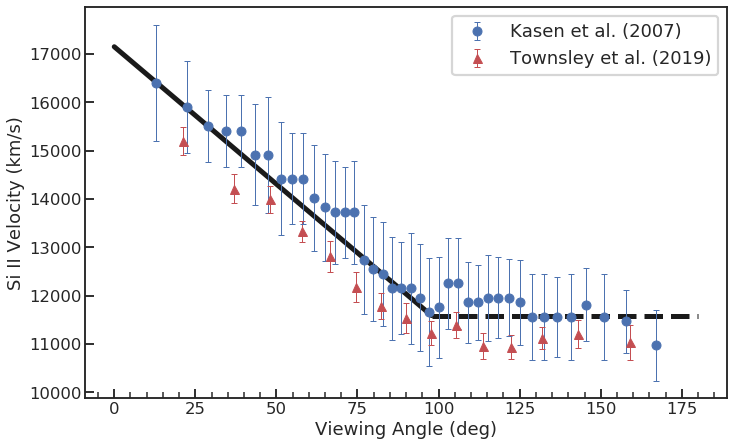

In [151]:
params, _ = curve_fit(piecewise_linear, np.concatenate([kasen_model['viewing_angle'], townsley_model['viewing_angle']]), np.concatenate([kasen_model['v_siII'], townsley_model['v_siII']]), p0=[100, 12000, -4000/60])

x = np.linspace(0, 180,1000)
plt.errorbar(kasen_model['viewing_angle'], kasen_model['v_siII'], yerr=kasen_model['v_siII_err'], 
             fmt='o', elinewidth=1, capsize=3, capthick=1, zorder=2, label='Kasen et al. (2007)')
plt.errorbar(townsley_model['viewing_angle'], townsley_model['v_siII'], yerr=townsley_model['v_siII_err'], 
             fmt='^', elinewidth=1, capsize=3, capthick=1, color='r', zorder=2, label='Townsley et al. (2019)')
plt.plot(x[x <= params[0]], piecewise_linear(x, *params)[x <= params[0]], color='k', lw=5, zorder=1)
plt.plot(x[x > params[0]], piecewise_linear(x, *params)[x > params[0]], color='k', lw=5, zorder=1, ls='--')

# ytickslabel = np.array(plt.yticks()[0]).astype(int).astype(str)
# ytickslabel[::2] = ''
# plt.yticks(plt.yticks()[0], ytickslabel)

# xticks = np.arange(0, 181, 10)
# xtickslabel = xticks.astype(str)
# xtickslabel[1::2] = ''
# plt.xticks(xticks, xtickslabel)

plt.xlabel('Viewing Angle (deg)')
plt.ylabel('Si II Velocity (km/s)')
plt.tight_layout(pad=0)
plt.legend()

# Method

Assumptions:

* Velocity of the Si II as a function of line of sight $\phi$ around the photosphere is inspired by the results of [2] and [3] which supports a monotonic decrease of velocity from its maximum (chosen to be at $\phi = 0$)

* Velocities are symmetric along one axis where $v(\phi) = v(-\phi)$.

* We make the simplify the monotonic decrease to be linear in addition to a cutoff at some angle $\theta$ such that,

    $$
    v(\phi) = v_L + \begin{cases} \frac{\theta - \phi}{\theta}\Delta v\\ 0 \end{cases}
    $$
    
    Where $v_L$ is distributed from the low velocity Gaussian component fit of the data and $\Delta v$ and $\theta$ are treated as parameters.


2. [Kasen D. and Plewa T. 2007](https://iopscience.iop.org/article/10.1086/516834)
3. [Townsley, D. M., Miles, B. J., Shen, K. J. et al. 2019](https://iopscience.iop.org/article/10.3847/2041-8213/ab27cd)

## Parameter Estimation - Grid Search

Using the simulation above, the best estimated parameters is determined by a grid search amongst all two parameters. The range of the grid is given below. The interval syntax is range(low, high, step):

$$
\begin{align}
\theta  &\in \text{range}(0, 180, 5) \quad \text{[deg]}\\
\Delta v &\in \text{range}(3000,~ 7500,~ 500) \quad \text{[km/s]}
\end{align}
$$

In total, $N=|\theta|\cdot|\Delta v|$ sets of parameters were simulated. Each simulation was scored by the Kolmogorov-Smirov (KS) test.

## Case 1 - Two Types: One Spherical and One Asymmetric

In [132]:
# Import results
import pickle as pkl

with open('results/scores_v2.pkl', 'rb') as f:
    scores = pkl.load(f)

ks = scores['ks']
sort_idx = np.argsort(ks)

pvalues = scores['pvalue']
pvalues = pvalues[sort_idx]
ks = ks[sort_idx]

params = scores['params'][sort_idx]
v_sim = scores['v_sim'][sort_idx]

df = pd.DataFrame([
         ks,
         pvalues
     ], index=['ks', 'pvalues']).T

df['theta'] = [param['theta'] for param in params]
df['delta_v'] = [param['delta_v'] for param in params]
df.head()

,ks,pvalues,theta,delta_v
0,0.033753,0.871718,110,6500
1,0.033758,0.871593,115,5000
2,0.035201,0.837000,110,6000
3,0.037613,0.772748,115,5500
4,0.037623,0.772468,115,6000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


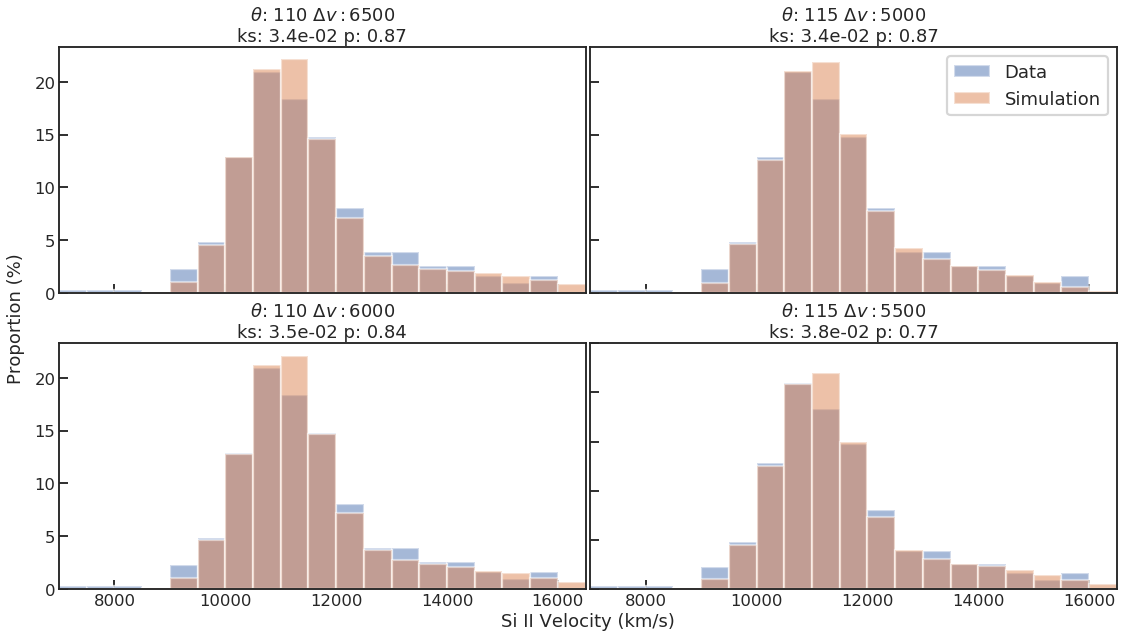

In [133]:
from scipy.stats import kstest, norm, ks_2samp

nrows, ncols = 2, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 4.5*nrows), sharex=True, sharey=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Si II Velocity (km/s)')
plt.ylabel("Proportion (%)")

for i in range(nrows*ncols):
    ax = axs[i//ncols, i%ncols]
    bins = np.arange(7000, 17000, 500)
    xrange = np.linspace(bins.min(), bins.max(), 200)
    param = params[i]
    
#     bimodal_params = np.loadtxt('bimodal_params.csv', delimiter=',')
#     lv_params = bimodal_params[:2]
#     hv_params = bimodal_params[2:-1]
#     mixing_param = bimodal_params[-1]
#     param = params[i]
    
    
    # Data
    l1 = ax.hist(sn_data['v_siII'], bins, density=True, alpha=0.5, label='Data')
    
    # LV Component
    
    # HV Component Data Fit
#     ax.plot(xrange, gaussian(xrange, *hv_params) * (1-mixing_param), '--b', label="Data HV Fit")
    
    # HV Simulation
    # Use HV from simulation and LV from sampling data fit
#     hv_samp = hvs[i]
    
    l2 = ax.hist(v_sim[i], bins, density=True, alpha=0.5, label="Simulation")
    
    # HV Component Simulation Fit
    # Gaussian fit on the simulation
#     ydata, xdata = np.histogram(hv_samp, bins=np.arange(0.8, 1.75, 0.1) * 10, density=True)
#     xdata = (xdata[:-1] + xdata[1:]) / 2
#     opt, cov = curve_fit(gaussian, xdata, ydata, p0=[np.mean(hv_samp), np.std(hv_samp)])
#     ax.plot(xrange, gaussian(xrange, *opt) * (1-mixing_param), '--r', label="Simulation HV Fit")

    
    # Plot config
    ax.set_title(f"$\\theta$: {param['theta']} $\Delta v: ${param['delta_v']}\nks: {ks[i]:.1e} p: {pvalues[i]:.2f}")
    ax.set_xlim(bins.min(), bins.max())
    yticks = ax.get_yticks() * 500 * 100
    yticks = np.arange(yticks.min(), yticks.max() + 1, 5) / (500 * 100)
    ytickslabel = [f'{tick:.2g}' for tick in yticks * 500 * 100]
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytickslabel)

plt.legend(*axs[0][0].get_legend_handles_labels(), loc='upper right')
plt.tight_layout(pad=0)
plt.savefig('results/grid_search_results_v2.eps', format='eps')

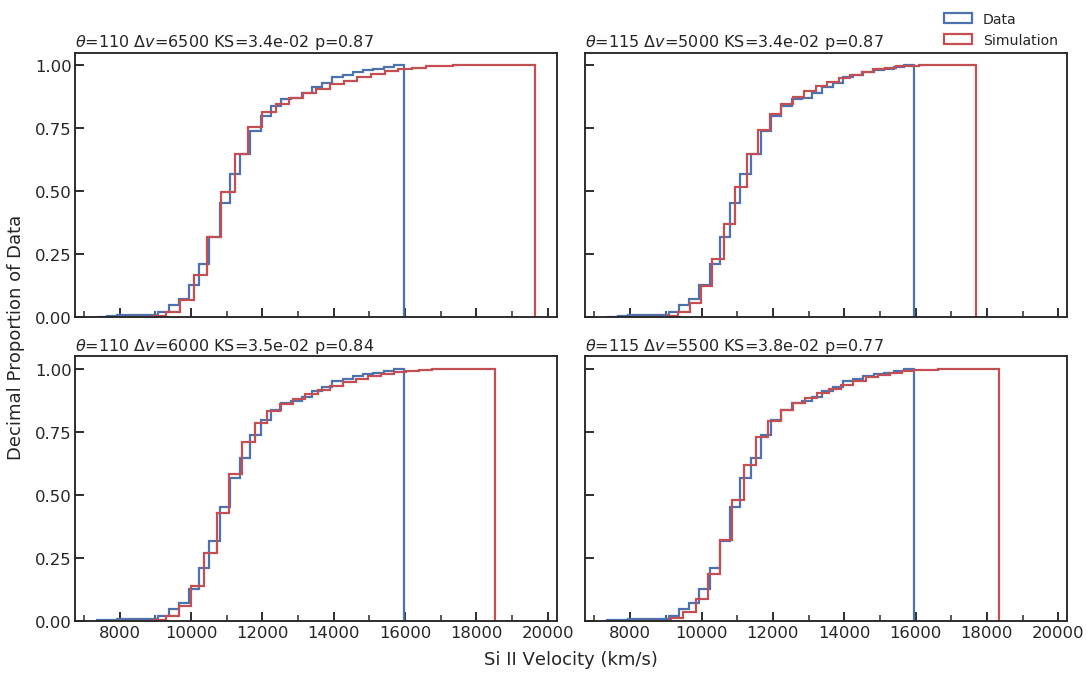

In [134]:
nrows, ncols = 2, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols, 5*nrows), sharex=True, sharey=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Si II Velocity (km/s)', labelpad=10)
plt.ylabel("Decimal Proportion of Data", labelpad=20)

for i in range(nrows*ncols):
    ax = axs[i//ncols, i%ncols]
    xrange = np.linspace(bins.min(), bins.max(), 200)
    param=params[i]

    ax.hist(sn_data['v_siII'], density=True, bins=30, histtype='step', cumulative=True, label='Data')
    ax.hist(v_sim[i], density=True, bins=30, color='r', histtype='step', cumulative=True, label='Simulation');
#     ax.plot(np.sort(v_sim[i]), np.arange(len(v_sim[i]))/len(v_sim[i]), 
#             label='Simulation', linewidth=4)
#     ax.plot(np.sort(sn_data['v_siII']), np.arange(len(sn_data))/len(sn_data), 
#             label='Data', linestyle='dashed', linewidth=4)
    
    # Plot config
    ax.set_title(f"$\\theta$={param['theta']} $\Delta v$={param['delta_v']} KS={ks[i]:.1e} p={pvalues[i]:.2f}", loc="left", fontsize=16)
    ax.set_xticks(np.arange(7000, 20000, 2000), minor=True)
                 
    yticks = np.arange(0, 101, 25) / 100
    ax.set_yticks(yticks)

plt.legend(*axs[0][0].get_legend_handles_labels(), loc=(0.87, 1), frameon=False, fontsize=14)
plt.tight_layout(pad=1)
plt.savefig('results/grid_search_cumulative_results_v2.eps', format='eps', dpi=800)

113.37985182018267 [103.92723529 122.83246835] [ 94.47461876 132.28508488]


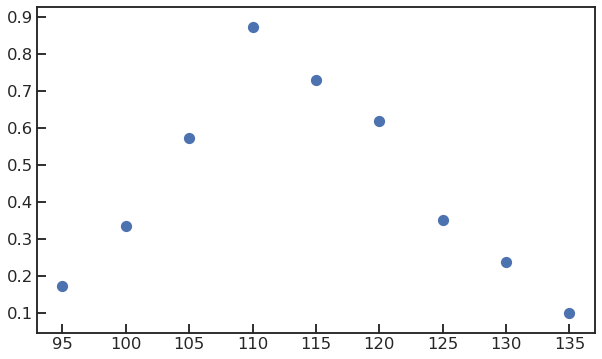

In [135]:
def get_stats(x, pvalues):
    pvalues = pvalues / np.sum(pvalues)  # Sanity normalization
    mean = np.sum(pvalues * x)
    sd = np.sqrt(np.sum((x - mean)**2 * pvalues))
    
    return mean, sd

_ = df.loc[df['delta_v'] == 6500, :]
plt.scatter(_['theta'], _['pvalues'])
mean, sd = get_stats(_['theta'], _['pvalues'])
print(mean, mean + np.array([-sd, sd]), mean + 2*np.array([-sd, sd]))
del _

5563.192782968145 [4561.58777346 6564.79779248] [3559.98276394 7566.40280199]


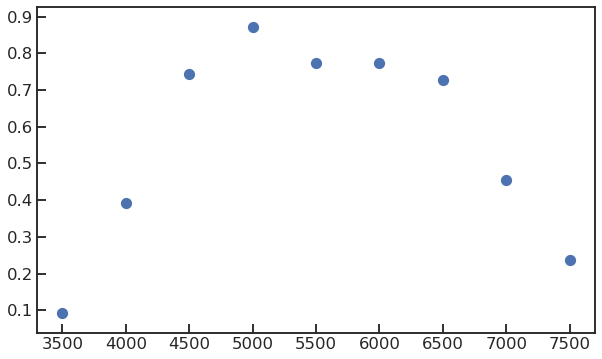

In [136]:
_ = df.loc[df['theta'] == 115, :]
plt.scatter(_['delta_v'], _['pvalues'])
mean, sd = get_stats(_['delta_v'], _['pvalues'])
print(mean, mean + np.array([-sd, sd]), mean + 2*np.array([-sd, sd]))
del _

Plotted above is the top KS scoring simulation. The bottom plot is the same plot as the previous figure. The top plot is the cumulative distirbution of the bottom.

## Case 2 - One Type: All Asymmetric

In [137]:
# Import results
import pickle as pkl

with open('results/scores_v3.pkl', 'rb') as f:
    scores = pkl.load(f)

ks = scores['ks']
sort_idx = np.argsort(ks)

pvalues = scores['pvalue']
pvalues = pvalues[sort_idx]
ks = ks[sort_idx]

params = scores['params'][sort_idx]
v_sim = scores['v_sim'][sort_idx]

df = pd.DataFrame([
         ks,
         pvalues
     ], index=['ks', 'pvalues']).T

df['theta'] = [param['theta'] for param in params]
df['delta_v'] = [param['delta_v'] for param in params]
df.head()

,ks,pvalues,theta,delta_v
0,0.034163,0.862243,60,6500
1,0.035036,0.841143,60,7000
2,0.036461,0.804279,60,6000
3,0.041661,0.654869,60,5500
4,0.042263,0.637007,65,4500


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


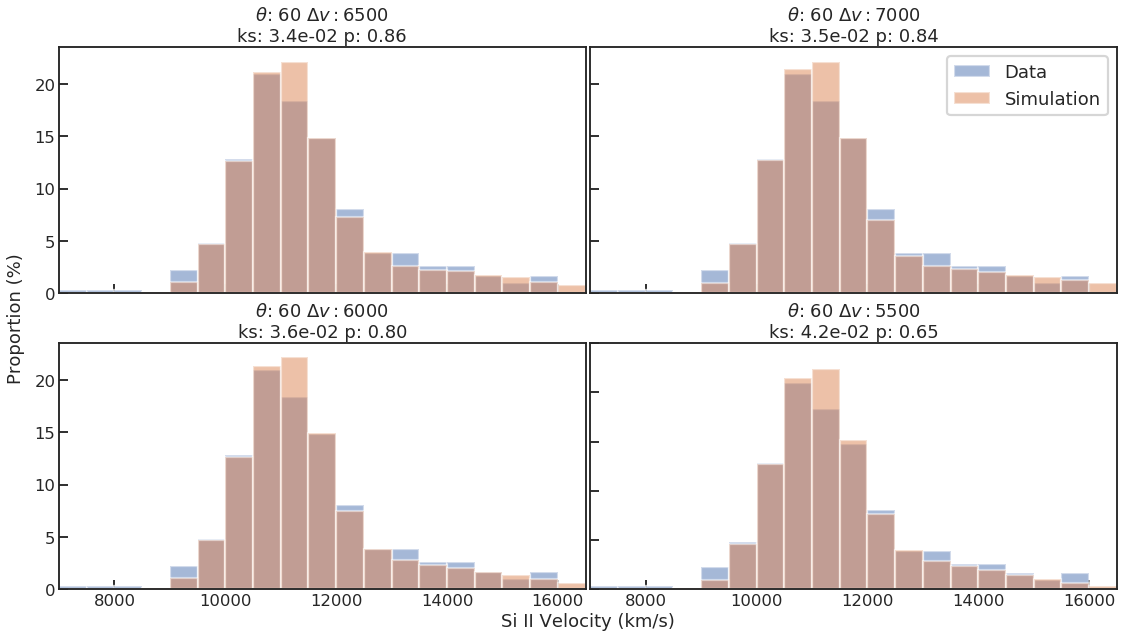

In [138]:
from scipy.stats import kstest, norm, ks_2samp

nrows, ncols = 2, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 4.5*nrows), sharex=True, sharey=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Si II Velocity (km/s)')
plt.ylabel("Proportion (%)")

for i in range(nrows*ncols):
    ax = axs[i//ncols, i%ncols]
    bins = np.arange(7000, 17000, 500)
    xrange = np.linspace(bins.min(), bins.max(), 200)
    param = params[i]
    
#     bimodal_params = np.loadtxt('bimodal_params.csv', delimiter=',')
#     lv_params = bimodal_params[:2]
#     hv_params = bimodal_params[2:-1]
#     mixing_param = bimodal_params[-1]
#     param = params[i]
    
    
    # Data
    l1 = ax.hist(sn_data['v_siII'], bins, density=True, alpha=0.5, label='Data')
    
    # LV Component
    
    # HV Component Data Fit
#     ax.plot(xrange, gaussian(xrange, *hv_params) * (1-mixing_param), '--b', label="Data HV Fit")
    
    # HV Simulation
    # Use HV from simulation and LV from sampling data fit
#     hv_samp = hvs[i]
    
    l2 = ax.hist(v_sim[i], bins, density=True, alpha=0.5, label="Simulation")
    
    # HV Component Simulation Fit
    # Gaussian fit on the simulation
#     ydata, xdata = np.histogram(hv_samp, bins=np.arange(0.8, 1.75, 0.1) * 10, density=True)
#     xdata = (xdata[:-1] + xdata[1:]) / 2
#     opt, cov = curve_fit(gaussian, xdata, ydata, p0=[np.mean(hv_samp), np.std(hv_samp)])
#     ax.plot(xrange, gaussian(xrange, *opt) * (1-mixing_param), '--r', label="Simulation HV Fit")

    
    # Plot config
    ax.set_title(f"$\\theta$: {param['theta']} $\Delta v: ${param['delta_v']}\nks: {ks[i]:.1e} p: {pvalues[i]:.2f}")
    ax.set_xlim(bins.min(), bins.max())
    yticks = ax.get_yticks() * 500 * 100
    yticks = np.arange(yticks.min(), yticks.max() + 1, 5) / (500 * 100)
    ytickslabel = [f'{tick:.2g}' for tick in yticks * 500 * 100]
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytickslabel)

plt.legend(*axs[0][0].get_legend_handles_labels(), loc='upper right')
plt.tight_layout(pad=0)
plt.savefig('results/grid_search_results_v3.eps', format='eps')

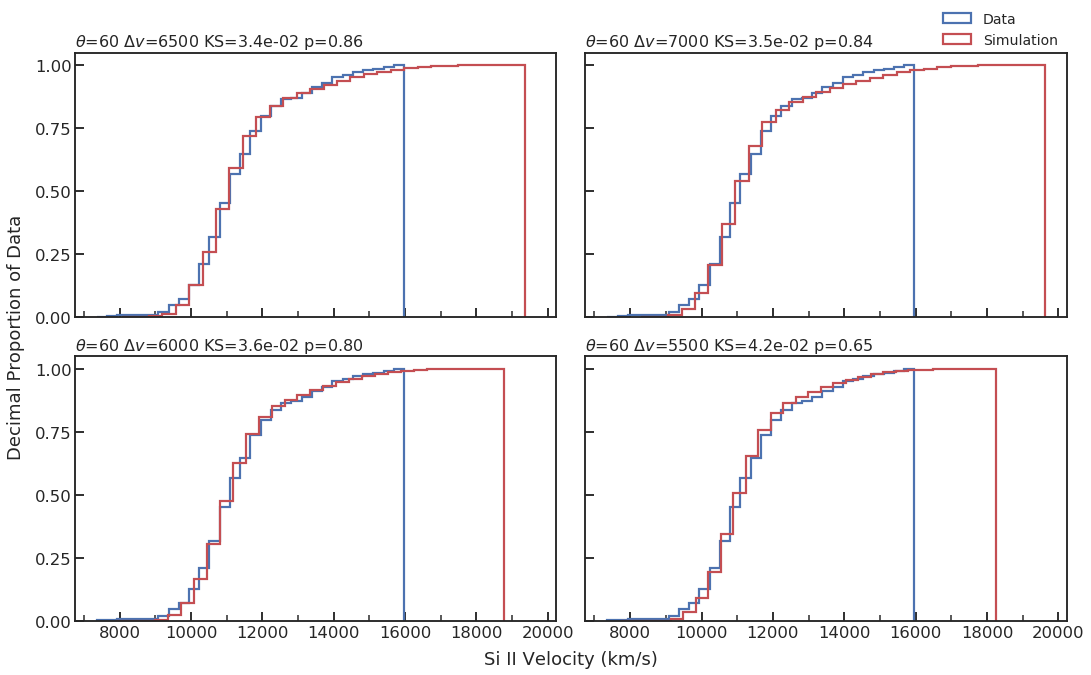

In [139]:
nrows, ncols = 2, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols, 5*nrows), sharex=True, sharey=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Si II Velocity (km/s)', labelpad=10)
plt.ylabel("Decimal Proportion of Data", labelpad=20)

for i in range(nrows*ncols):
    ax = axs[i//ncols, i%ncols]
    xrange = np.linspace(bins.min(), bins.max(), 200)
    param=params[i]

    ax.hist(sn_data['v_siII'], density=True, bins=30, histtype='step', cumulative=True, label='Data')
    ax.hist(v_sim[i], density=True, bins=30, color='r', histtype='step', cumulative=True, label='Simulation');
#     ax.plot(np.sort(v_sim[i]), np.arange(len(v_sim[i]))/len(v_sim[i]), 
#             label='Simulation', linewidth=4)
#     ax.plot(np.sort(sn_data['v_siII']), np.arange(len(sn_data))/len(sn_data), 
#             label='Data', linestyle='dashed', linewidth=4)
    
    # Plot config
    ax.set_title(f"$\\theta$={param['theta']} $\Delta v$={param['delta_v']} KS={ks[i]:.1e} p={pvalues[i]:.2f}", loc="left", fontsize=16)
    ax.set_xticks(np.arange(7000, 20000, 2000), minor=True)
                 
    yticks = np.arange(0, 101, 25) / 100
    ax.set_yticks(yticks)

plt.legend(*axs[0][0].get_legend_handles_labels(), loc=(0.87, 1), frameon=False, fontsize=14)
plt.tight_layout(pad=1)
plt.savefig('results/grid_search_cumulative_results_v3.eps', format='eps', dpi=800)

61.12214089212417 [56.40388988 65.8403919 ] [51.68563887 70.55864291]


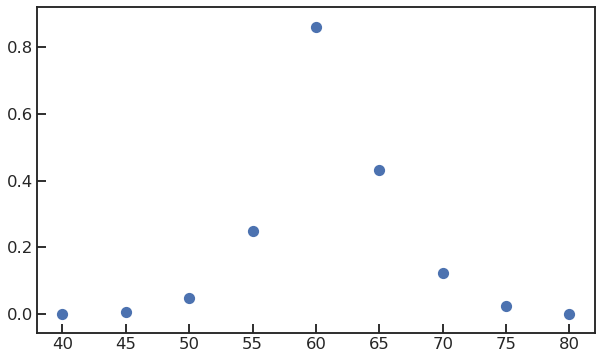

In [140]:
def get_stats(x, pvalues):
    pvalues = pvalues / np.sum(pvalues)  # Sanity normalization
    mean = np.sum(pvalues * x)
    sd = np.sqrt(np.sum((x - mean)**2 * pvalues))
    
    return mean, sd

_ = df.loc[df['delta_v'] == 6500, :]
plt.scatter(_['theta'], _['pvalues'])
mean, sd = get_stats(_['theta'], _['pvalues'])
print(mean, mean + np.array([-sd, sd]), mean + 2*np.array([-sd, sd]))
del _

0.0 [0. 0.] [0. 0.]


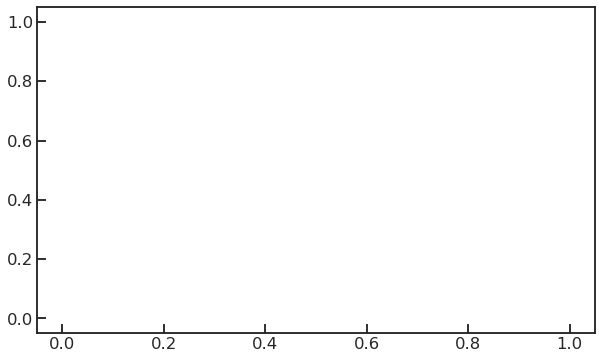

In [111]:
_ = df.loc[df['theta'] == 115, :]
plt.scatter(_['delta_v'], _['pvalues'])
mean, sd = get_stats(_['delta_v'], _['pvalues'])
print(mean, mean + np.array([-sd, sd]), mean + 2*np.array([-sd, sd]))
del _

Plotted above is the top KS scoring simulation. The bottom plot is the same plot as the previous figure. The top plot is the cumulative distirbution of the bottom.

# Discussion

The distinction in Si II velocity distribution may be described by asymmetries in SNe Ia's ejecta. We produced a two-dimensional simulation under the assumption that the ejecta asymmetries is only angular (i.e., the ejecta is anisotropic) where the there exist a angular region on the photospheric shell that has a velocity higher than the remaining shell. These two region are labeled as high-velocity ejecta (HV) and low-velocity ejecta (LV). We assume for a given SN Ia, its LV ejecta velocity is constant while the HV ejecta velocity follows a linear uniformily increasing function with minimum value of the LV ejecta velocity. The best performing simulations resulted in reasonable and consistent values with Kasen D. & Plewa T. (2007) and Townsley et al. (2019). 

## Slides

DD and Off-center to explain V2

1. Explain progenitor
2. How to measure velocity using Si II line
3. Show velocity data (size 311), and bimodal fitting. Motivate two component using Wang, Polen A. 
4. Justify bimodal fitting using maximum likelihood ratio. Use chi-2, pvalue, AICC (2*lnlike + 2*nparams + (2*nparams**2 + 2*nparams) / (sample_size - nparams - 1))
5. Motivate the simulation given Kasen and Ken's models.
6. Explain the V2 simulation (make diagram of the model)
7. Results plot KS dist then immediately the cumulative one.
8. Conclusion, plot pvalue vs theta or delta_v, report confidence interval for each parameter. Compare back with other people's results
---
9. V3
10. Conclusion

# References

Hillebrandt, W., & Niemeyer, J. C. 2000, ARA&A, 38, 191

Kasen D. & Plewa T. 2007, ApJ, 662, 1

Levanon, N., & Soker, N. 2019, arXiv:1901.05057

Polin, A., Nugent, P. E., & Kasen, D. 2019, ApJ, 873, 1

Silverman, J. M., Kong, J. J., Filippenko, A. V., et al. 2012, MNRAS, 425, 1819

Townsley, D. M., Miles, B. J., Shen, K. J. et al. 2019, ApJ, 878, 2

Wang, X., Wang, L., & Filippenko, A. V. 2013, Science, 340, 6129

Zheng, W., Kelly, P. L., & Filippenko, A. V. 2018, ApJ, 858, 104

# Appendix

## Sampling a Uniform Spherical from 3D to 2D

For a uniformly distributed sphere in 3D, the projection down to 2D on the x-z plane where $\phi$ (the colongitude angle) disappears, the probability distribution as a function of $\theta$ (the colatitude angle) is,

$$
P(\theta) = \frac{1}{2} \sin{\theta}
$$

Sampling this distribution requires a trick where we take the uniform random variable $U ~ [0,1]$ and apply the transformation:

$$
u \in U\\
\theta = \arccos(2u - 1)
$$

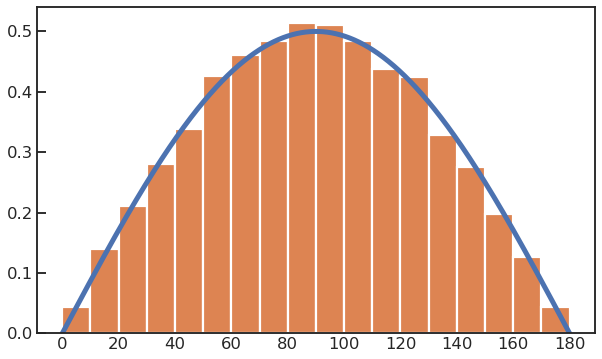

In [54]:
def pdf(theta):
    return -np.sin(theta)/2

# Plot the true PDF
theta = np.linspace(0,np.pi,10000)

# Sample with special trick
v = np.random.uniform(0,1, 10000)
theta_samples = np.arccos(2*v - 1)
# theta_samples = np.pi/2 - theta_samples
# theta_samples[theta_samples < 0] = theta_samples[theta_samples < 0]

bins = np.radians(np.arange(0,181,10))
plt.plot(theta, np.abs(pdf(theta)))
plt.hist(theta_samples, density=True, bins=bins);
plt.xticks(ticks=bins[::2], labels=[f"{xtick/np.pi * 180:.0f}" for xtick in bins[::2]]);

In [55]:
_ = pd.read_csv('data/SN2013dy_spectra.txt', sep='\s+', names=['wavelength', 'flux'])
plt.figure(figsize=(10,6))
plt.plot(_['wavelength'], _['flux'], 'k')
plt.axvline(6355, color='r')
plt.xlim(5500, 6500)
plt.xlabel('Observed Wavelength [$\AA$]')
plt.ylabel('Observed Brightness')

plt.tight_layout(pad=0)
plt.savefig('results/SN2013dy_spectra.eps', format='eps')
del _

FileNotFoundError: [Errno 2] File b'data/SN2013dy_spectra.txt' does not exist: b'data/SN2013dy_spectra.txt'